In [857]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
import itertools
import re
import matplotlib.ticker as mtick


In [858]:
!gdown --id 1vXs_8uGV0e6gT6i5JeXMmYThlJQNdbcq

Downloading...
From: https://drive.google.com/uc?id=1vXs_8uGV0e6gT6i5JeXMmYThlJQNdbcq
To: /content/netflix-rotten-tomatoes-metacritic-imdb.csv
14.8MB [00:00, 90.1MB/s]


In [859]:
df = pd.read_csv('/content/netflix-rotten-tomatoes-metacritic-imdb.csv')

In [860]:
df.head()

,Title,Genre,Tags,Languages,Series or Movie,Hidden Gem Score,Country Availability,Runtime,Director,Writer,Actors,View Rating,IMDb Score,Rotten Tomatoes Score,Metacritic Score,Awards Received,Awards Nominated For,Boxoffice,Release Date,Netflix Release Date,Production House,Netflix Link,IMDb Link,Summary,IMDb Votes,Image,Poster,TMDb Trailer,Trailer Site
0,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance","Comedy Programmes,Romantic TV Comedies,Horror ...","Swedish, Spanish",Series,4.3,Thailand,< 30 minutes,Tomas Alfredson,John Ajvide Lindqvist,"Kåre Hedebrant, Per Ragnar, Lina Leandersson, ...",R,7.9,98.0,82.0,74.0,57.0,"$2,122,065",12 Dec 2008,2021-03-04,"Canal+, Sandrew Metronome",https://www.netflix.com/watch/81415947,https://www.imdb.com/title/tt1139797,A med student with a supernatural gift tries t...,205926.0,https://occ-0-4708-64.1.nflxso.net/dnm/api/v6/...,https://m.media-amazon.com/images/M/MV5BOWM4NT...,NaN,NaN
1,HOW TO BUILD A GIRL,Comedy,"Dramas,Comedies,Films Based on Books,British",English,Movie,7.0,Canada,1-2 hour,Coky Giedroyc,Caitlin Moran,"Paddy Considine, Cleo, Beanie Feldstein, Dónal...",R,5.8,79.0,69.0,1.0,NaN,"$70,632",08 May 2020,2021-03-04,"Film 4, Monumental Pictures, Lionsgate",https://www.netflix.com/watch/81041267,https://www.imdb.com/title/tt4193072,"When nerdy Johanna moves to London, things get...",2838.0,https://occ-0-1081-999.1.nflxso.net/dnm/api/v6...,https://m.media-amazon.com/images/M/MV5BZGUyN2...,https://www.youtube.com/watch?v=eIbcxPy4okQ,YouTube
2,Centigrade,"Drama, Thriller",Thrillers,English,Movie,6.4,Canada,1-2 hour,Brendan Walsh,"Brendan Walsh, Daley Nixon","Genesis Rodriguez, Vincent Piazza",Unrated,4.3,NaN,46.0,NaN,NaN,"$16,263",28 Aug 2020,2021-03-04,NaN,https://www.netflix.com/watch/81305978,https://www.imdb.com/title/tt8945942,"Trapped in a frozen car during a blizzard, a p...",1720.0,https://occ-0-1081-999.1.nflxso.net/dnm/api/v6...,https://m.media-amazon.com/images/M/MV5BODM2MD...,https://www.youtube.com/watch?v=0RvV7TNUlkQ,YouTube
3,ANNE+,Drama,"TV Dramas,Romantic TV Dramas,Dutch TV Shows",Turkish,Series,7.7,"Belgium,Netherlands",< 30 minutes,NaN,NaN,"Vahide Perçin, Gonca Vuslateri, Cansu Dere, Be...",NaN,6.5,NaN,NaN,1.0,NaN,NaN,01 Oct 2016,2021-03-04,NaN,https://www.netflix.com/watch/81336456,https://www.imdb.com/title/tt6132758,"Upon moving into a new place, a 20-something r...",1147.0,https://occ-0-1489-1490.1.nflxso.net/dnm/api/v...,https://m.media-amazon.com/images/M/MV5BNWRkMz...,NaN,NaN
4,Moxie,"Animation, Short, Drama","Social Issue Dramas,Teen Movies,Dramas,Comedie...",English,Movie,8.1,"Lithuania,Poland,France,Iceland,Italy,Spain,Gr...",1-2 hour,Stephen Irwin,NaN,Ragga Gudrun,NaN,6.3,NaN,NaN,NaN,4.0,NaN,22 Sep 2011,2021-03-04,NaN,https://www.netflix.com/watch/81078393,https://www.imdb.com/title/tt2023611,Inspired by her moms rebellious past and a con...,63.0,https://occ-0-4039-1500.1.nflxso.net/dnm/api/v...,https://m.media-amazon.com/images/M/MV5BODYyNW...,NaN,NaN


# Предобработка

# Удаление столбцов
Удаление ненужный для анализа столбцов

Также оставим только рейтинт IMBD и будем использовать его для анализа

In [861]:
df.columns

Index(['Title', 'Genre', 'Tags', 'Languages', 'Series or Movie',
       'Hidden Gem Score', 'Country Availability', 'Runtime', 'Director',
       'Writer', 'Actors', 'View Rating', 'IMDb Score',
       'Rotten Tomatoes Score', 'Metacritic Score', 'Awards Received',
       'Awards Nominated For', 'Boxoffice', 'Release Date',
       'Netflix Release Date', 'Production House', 'Netflix Link', 'IMDb Link',
       'Summary', 'IMDb Votes', 'Image', 'Poster', 'TMDb Trailer',
       'Trailer Site'],
      dtype='object')

In [862]:
df.drop(columns= ['Hidden Gem Score','Rotten Tomatoes Score', 'Metacritic Score', 'Netflix Release Date', 'Production House', 'Netflix Link', 'IMDb Link',
       'Summary', 'Image', 'Poster', 'TMDb Trailer', 'Country Availability',
       'Trailer Site'],inplace=True)

In [863]:
df.columns

Index(['Title', 'Genre', 'Tags', 'Languages', 'Series or Movie', 'Runtime',
       'Director', 'Writer', 'Actors', 'View Rating', 'IMDb Score',
       'Awards Received', 'Awards Nominated For', 'Boxoffice', 'Release Date',
       'IMDb Votes'],
      dtype='object')

In [864]:
len(df.index)

15480

Удалим все записи без рейтинга (так как он нам необходим для анализа и записи без него просто бесполезны для нас)

In [865]:
df = df[df['IMDb Score'].notna()]

Теперь дропним записи которые могут неправильно повлиять на анализ, например если кол-во голосов для рейтинга слишком маленькое для адекватного результата

*Плюс пандовский дроп жрет кучу памяти и бесплатный коллаб не справляется по памяти*

In [866]:
df.drop(df[df['IMDb Votes'] < 1000].index, inplace=True)

In [867]:
len(df.index)

8352

Конвертируем тип данных где необходимо

In [868]:
df["Boxoffice"] = df["Boxoffice"][df["Boxoffice"].notnull()].replace('[\$,\ ]', '', regex=True).astype(int)


In [869]:
df.isna().mean()

Title                   0.000000
Genre                   0.000120
Tags                    0.003951
Languages               0.006944
Series or Movie         0.000000
Runtime                 0.000120
Director                0.176485
Writer                  0.105723
Actors                  0.002035
View Rating             0.157567
IMDb Score              0.000000
Awards Received         0.414990
Awards Nominated For    0.275144
Boxoffice               0.536039
Release Date            0.008022
IMDb Votes              0.000239
dtype: float64

In [870]:
df.isna().mean()

Title                   0.000000
Genre                   0.000120
Tags                    0.003951
Languages               0.006944
Series or Movie         0.000000
Runtime                 0.000120
Director                0.176485
Writer                  0.105723
Actors                  0.002035
View Rating             0.157567
IMDb Score              0.000000
Awards Received         0.414990
Awards Nominated For    0.275144
Boxoffice               0.536039
Release Date            0.008022
IMDb Votes              0.000239
dtype: float64

Разделим все столбцы с категориальными данными на отдельные столбцы

Не будем создавать столбцы с записями у которых частота появления меньше 5% (например жанры: game-show, talk-show, news)

In [871]:
def lerp(start, end, factor):
  return (start * (1.0 - factor)) + (end * factor);
def OHEColumn(dataframe,columnName):
  rowCount = len(df.index)
  if columnName not in df.columns:
    return None
  temp = pd.Series(dataframe[columnName])
  temp = temp.fillna("no_info")
  temp = temp.str.replace(', ',',')
  temp = temp.str.replace(' ,',',').str.lower()
  temp = temp.str.split(pat = ",")

  countes = Counter()
  for xs in temp:
    for x in set(xs):
      countes[x] += 1


  itemsToRemove = []
  for key, value in itertools.islice(countes.items(), 1, None): 
    if value < 3: # не включаем меньше трех записей
      itemsToRemove.append(key)

  print("Будут удаленны следующие записи из столбца " + str(columnName) + ": " + str(itemsToRemove))

  for y in temp:
    for d in itemsToRemove:
      if(d in y):
        y.remove(d)
      

  mlb = MultiLabelBinarizer()
  dummies_df = pd.DataFrame(mlb.fit_transform(temp),
                   columns=mlb.classes_,
                   index=temp.index)
  if "na" in dummies_df.columns:
    dummies_df = dummies_df.drop(columns = "no_info")
  dummies_df.columns = [columnName + "_" + str(c) for c in dummies_df.columns]
  
  return dummies_df

columnsToOHE = ['Genre', 'Tags', 'Director', 'Writer', 'Actors', 'Languages', "View Rating"]
for col in columnsToOHE:
  ohe = OHEColumn(df, col)
  if not isinstance(ohe, pd.DataFrame):
    continue
  df.drop(columns = col, inplace = True)
  df = df.join(ohe)



df.head()


Будут удаленны следующие записи из столбца Genre: ['no_info']
Будут удаленны следующие записи из столбца Tags: ['dutch tv shows', 'bengali-language films', 'spanish', 'education for kids', 'indian programmes', 'middle eastern tv programmes', 'south african tv shows', 'hindi-language tv programmes', 'austrian movies', 'german documentaries', 'dance non-fiction', 'bengali-language movies', 'swedish tv programmes', 'mainland chinese tv shows', 'peruvian movies', 'telugu-language films', 'romantic comedy anime', 'colombian tv shows', 'romantic tv soaps', 'latin american music & musicals', 'brazilian tv programmes', 'italian tv programmes', 'mexican music & musicals', 'vampire movies', 'special interest', 'deep sea horror films', 'wine & beverage appreciation', 'polish action & adventure', 'romantic swedish movies', 'brazilian music & musicals', 'brazilian music and concert movies', 'swedish comedies', 'punjabi-language movies', 'finnish movies', 'crime docuseries', 'dance', 'theatre arts',

,Title,Series or Movie,Runtime,IMDb Score,Awards Received,Awards Nominated For,Boxoffice,Release Date,IMDb Votes,Genre_action,Genre_adventure,Genre_animation,Genre_biography,Genre_comedy,Genre_crime,Genre_documentary,Genre_drama,Genre_family,Genre_fantasy,Genre_game-show,Genre_history,Genre_horror,Genre_music,Genre_musical,Genre_mystery,Genre_news,Genre_reality-tv,Genre_romance,Genre_sci-fi,Genre_short,Genre_sport,Genre_talk-show,Genre_thriller,Genre_war,Genre_western,Tags_20th century period pieces,Tags_20th-century period pieces,Tags_absurd comedies,Tags_academy award-winning films,Tags_action,...,Languages_sign languages,Languages_sindarin,Languages_slovak,Languages_somali,Languages_spanish,Languages_swahili,Languages_swedish,Languages_swiss german,Languages_tagalog,Languages_tamil,Languages_telugu,Languages_thai,Languages_tibetan,Languages_turkish,Languages_ukrainian,Languages_urdu,Languages_vietnamese,Languages_welsh,Languages_wolof,Languages_xhosa,Languages_yiddish,Languages_zulu,View Rating_approved,View Rating_g,View Rating_gp,View Rating_nc-17,View Rating_no_info,View Rating_not rated,View Rating_passed,View Rating_pg,View Rating_pg-13,View Rating_r,View Rating_tv-14,View Rating_tv-g,View Rating_tv-ma,View Rating_tv-pg,View Rating_tv-y,View Rating_tv-y7,View Rating_tv-y7-fv,View Rating_unrated
0,Lets Fight Ghost,Series,< 30 minutes,7.9,74.0,57.0,2122065.0,12 Dec 2008,205926.0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,HOW TO BUILD A GIRL,Movie,1-2 hour,5.8,1.0,NaN,70632.0,08 May 2020,2838.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,Centigrade,Movie,1-2 hour,4.3,NaN,NaN,16263.0,28 Aug 2020,1720.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,ANNE+,Series,< 30 minutes,6.5,1.0,NaN,NaN,01 Oct 2016,1147.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Snowroller,Movie,1-2 hour,6.6,NaN,NaN,NaN,04 Oct 1985,5926.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


*Oof! Thats a lot of columns...*
И столбцов могло быть более 23К без чистки 

Ловеркезим названия столбцов и убираем пробелы для удобства

In [872]:
df.columns = df.columns.str.replace(' ','_').str.lower()

In [873]:
df.columns

Index(['title', 'series_or_movie', 'runtime', 'imdb_score', 'awards_received',
       'awards_nominated_for', 'boxoffice', 'release_date', 'imdb_votes',
       'genre_action',
       ...
       'view_rating_pg-13', 'view_rating_r', 'view_rating_tv-14',
       'view_rating_tv-g', 'view_rating_tv-ma', 'view_rating_tv-pg',
       'view_rating_tv-y', 'view_rating_tv-y7', 'view_rating_tv-y7-fv',
       'view_rating_unrated'],
      dtype='object', length=5757)

Дополнительный столбец для удобства

In [874]:
df['imdb_score_group'] = pd.qcut(df['imdb_score'],5,["0-2","2-4","4-6","6-8","8-10"])

И под конец разделим таблицу на фильмы и сериалы

In [875]:
movies = df[df['series_or_movie'] == "Movie"]
movies.drop(columns= "series_or_movie", inplace=True)
series = df[df['series_or_movie'] == "Series"]
series.drop(columns= "series_or_movie", inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [876]:
series.count()

title                   1581
runtime                 1580
imdb_score              1581
awards_received          825
awards_nominated_for    1030
                        ... 
view_rating_tv-y        1581
view_rating_tv-y7       1581
view_rating_tv-y7-fv    1581
view_rating_unrated     1581
imdb_score_group        1581
Length: 5757, dtype: int64

# Анализ

Распределение рейтинга по записям

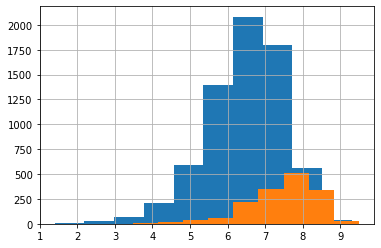

In [877]:
movies.imdb_score.hist()
series.imdb_score.hist()

Здесь можно предположить что рейтинг зависит от длинны фильма, но...

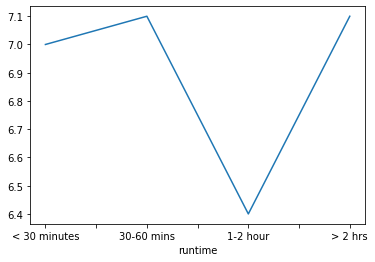

In [878]:
movies.groupby('runtime')['imdb_score'].median().reindex(["< 30 minutes", "30-60 mins", "1-2 hour", "> 2 hrs"]).plot()

На самом деле распределенние данных по длинне фильма неравномерное и количество записей недостаточно для точного анализа

In [879]:
movies.value_counts("runtime")

runtime
1-2 hour        5207
> 2 hrs         1435
30-60 mins        67
< 30 minutes      62
dtype: int64

In [880]:
movies.head()

,title,runtime,imdb_score,awards_received,awards_nominated_for,boxoffice,release_date,imdb_votes,genre_action,genre_adventure,genre_animation,genre_biography,genre_comedy,genre_crime,genre_documentary,genre_drama,genre_family,genre_fantasy,genre_game-show,genre_history,genre_horror,genre_music,genre_musical,genre_mystery,genre_news,genre_reality-tv,genre_romance,genre_sci-fi,genre_short,genre_sport,genre_talk-show,genre_thriller,genre_war,genre_western,tags_20th_century_period_pieces,tags_20th-century_period_pieces,tags_absurd_comedies,tags_academy_award-winning_films,tags_action,tags_action_&_adventure,...,languages_sindarin,languages_slovak,languages_somali,languages_spanish,languages_swahili,languages_swedish,languages_swiss_german,languages_tagalog,languages_tamil,languages_telugu,languages_thai,languages_tibetan,languages_turkish,languages_ukrainian,languages_urdu,languages_vietnamese,languages_welsh,languages_wolof,languages_xhosa,languages_yiddish,languages_zulu,view_rating_approved,view_rating_g,view_rating_gp,view_rating_nc-17,view_rating_no_info,view_rating_not_rated,view_rating_passed,view_rating_pg,view_rating_pg-13,view_rating_r,view_rating_tv-14,view_rating_tv-g,view_rating_tv-ma,view_rating_tv-pg,view_rating_tv-y,view_rating_tv-y7,view_rating_tv-y7-fv,view_rating_unrated,imdb_score_group
1,HOW TO BUILD A GIRL,1-2 hour,5.8,1.0,NaN,70632.0,08 May 2020,2838.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0-2
2,Centigrade,1-2 hour,4.3,NaN,NaN,16263.0,28 Aug 2020,1720.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0-2
9,Snowroller,1-2 hour,6.6,NaN,NaN,NaN,04 Oct 1985,5926.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4-6
11,The Invisible,1-2 hour,6.2,NaN,1.0,20578909.0,27 Apr 2007,34738.0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2-4
12,The Simple Minded Murderer,1-2 hour,7.6,7.0,2.0,NaN,01 Sep 1985,2870.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6-8


In [881]:
def addPopularityScore(data):
    data.columns = data.columns.add_categories('occurence')
    data.columns = data.columns.add_categories('popularity_score')
    list_occurence = []
    list_popularity_score = []
    for index, row in data.iterrows():
      sum = row.sum(axis=0)
      list_occurence.append(sum)
      list_popularity_score.append((row["0-2"] * -4 + row["2-4"] * -2 + row["4-6"] + row["6-8"] * 2 + row["8-10"] * 4)/sum)
    data["occurence"] = list_occurence
    data["popularity_score"] = list_popularity_score

def getGroupedPopularityTable(data,prefix):
  parseColumns = []
  for col in data.columns:
    if re.search("^" + prefix, col):
      parseColumns.append(col)
  returnData = data.groupby('imdb_score_group')[parseColumns].sum()
  returnData = returnData.T[returnData.any()]
  return returnData

Зависимости от возрастного рейтинга нету.

count      18.000000
mean      376.055556
std       572.433245
min         1.000000
25%        11.250000
50%        78.500000
75%       534.750000
max      1981.000000
Name: occurence, dtype: float64
18
14


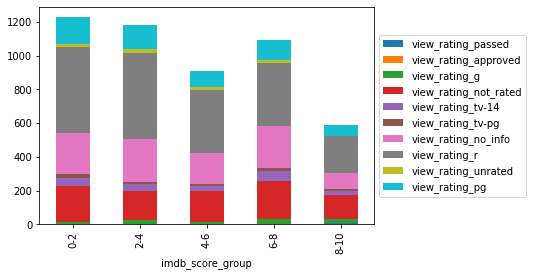

In [882]:
groupedData = getGroupedPopularityTable(movies,"view_rating_")
addPopularityScore(groupedData)

print(groupedData["occurence"].describe())
print(len(groupedData))
groupedData.drop(groupedData[groupedData['occurence'] < 10].index, inplace=True)
print(len(groupedData))
groupedData = groupedData.sort_values("popularity_score",ascending=False)

groupedData = groupedData.head(10)

groupedData.drop(columns= ["occurence", "popularity_score"], inplace= True)

groupedData = groupedData.T
groupedData.head(10)
groupedData.head(10).plot(use_index=True , y= groupedData.columns, kind="bar",rot=90, stacked=True).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

Выявляем зависимость от актеров и графики для 10 самых успешных актеров

Счет популярности вычисляется суммой записей умноженных на вес зависящий от рэйтинга и делением всего этого на частоту появления записей

**Тут есть очевидная зависимость**

count    2632.000000
mean        5.191109
std         4.261808
min         1.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        38.000000
Name: occurence, dtype: float64


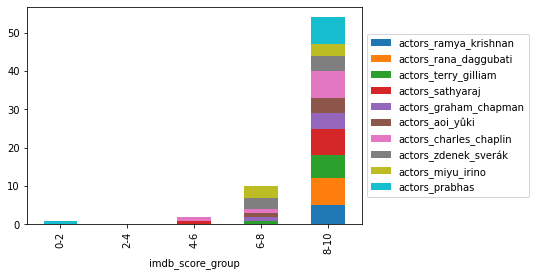

In [883]:
actors = getGroupedPopularityTable(movies,"actors_")
addPopularityScore(actors)

print(actors["occurence"].describe())
# дропаем актеров которые снялись меньше чем в 5 фильмах
actors.drop(actors[actors['occurence'] < 5].index, inplace=True)
actors = actors.sort_values("popularity_score",ascending=False)

actors = actors.head(10)

actors.drop(columns= ["occurence", "popularity_score"], inplace= True)

actors = actors.T
#actors.head(10)
actors.head(10).plot(use_index=True , y= actors.columns, kind="bar", stacked=True).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))



Тоже самое делаем для жанров

**Зависимости не обнаружилось**

count      25.000000
mean      778.160000
std       873.137145
min         1.000000
25%       203.000000
50%       484.000000
75%      1081.000000
max      3474.000000
Name: occurence, dtype: float64
25
14


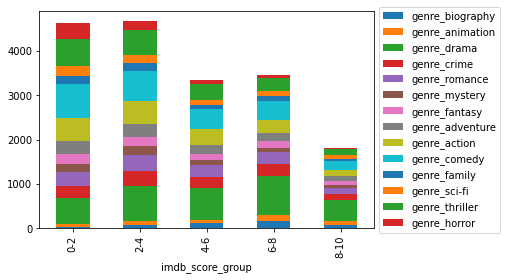

In [884]:
genres = getGroupedPopularityTable(movies,"genre_")
addPopularityScore(genres)

print(genres["occurence"].describe())
print(len(genres))
genres.drop(genres[genres['occurence'] < 350].index, inplace=True)
print(len(genres))
genres = genres.sort_values("popularity_score",ascending=False)

genres.drop(columns= ["occurence", "popularity_score"], inplace= True)

genres = genres.T
genres.head(10)
genres.head(10).plot(use_index=True , y= genres.columns, kind="bar", stacked=True).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

**Язык, зависимости нету**

count     100.000000
mean      108.280000
std       510.828819
min         2.000000
25%         5.000000
50%         9.500000
75%        44.500000
max      5000.000000
Name: occurence, dtype: float64
100
5


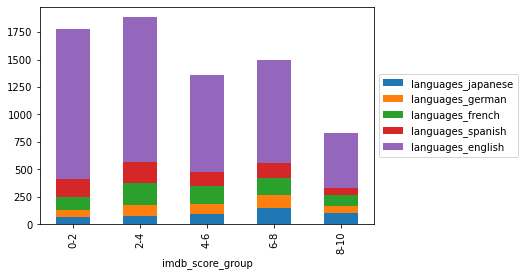

In [885]:
groupedData = getGroupedPopularityTable(movies,"languages_")
addPopularityScore(groupedData)

print(groupedData["occurence"].describe())
print(len(groupedData))
groupedData.drop(groupedData[groupedData['occurence'] < 350].index, inplace=True)
print(len(groupedData))
groupedData = groupedData.sort_values("popularity_score",ascending=False)

groupedData = groupedData.head(10)

groupedData.drop(columns= ["occurence", "popularity_score"], inplace= True)

groupedData = groupedData.T
groupedData.head(10)
groupedData.head(10).plot(use_index=True , y= groupedData.columns, kind="bar", stacked=True).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

**Тэги, Есть зависимости**

count     617.000000
mean       72.348460
std       194.995188
min         1.000000
25%         6.000000
50%        16.000000
75%        57.000000
max      2646.000000
Name: occurence, dtype: float64
617
171


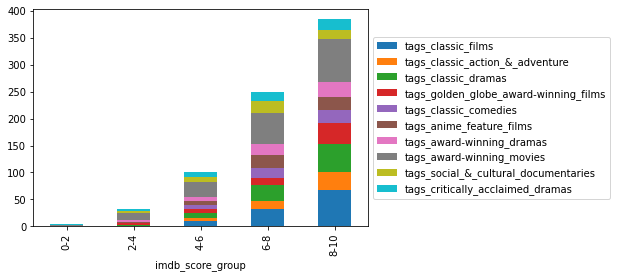

In [886]:
groupedData = getGroupedPopularityTable(movies,"tags_")
addPopularityScore(groupedData)

print(groupedData["occurence"].describe())
print(len(groupedData))
groupedData.drop(groupedData[groupedData['occurence'] < 50].index, inplace=True)
print(len(groupedData))
groupedData = groupedData.sort_values("popularity_score",ascending=False)

groupedData = groupedData.head(10)

groupedData.drop(columns= ["occurence", "popularity_score"], inplace= True)

groupedData = groupedData.T

groupedData.head(10).plot(use_index=True , y= groupedData.columns, kind="bar",rot=90, stacked=True).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

Есть зависимость от директора

count    713.000000
mean       4.652174
std        3.603942
min        2.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       75.000000
Name: occurence, dtype: float64
713
388


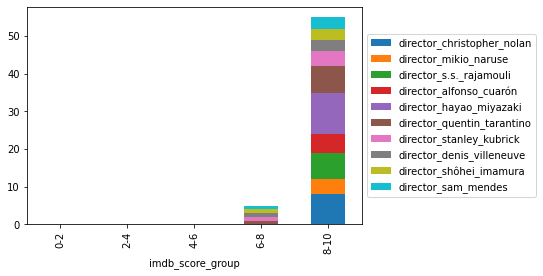

In [887]:
groupedData = getGroupedPopularityTable(movies,"director_")
addPopularityScore(groupedData)

print(groupedData["occurence"].describe())
print(len(groupedData))
groupedData.drop(groupedData[groupedData['occurence'] < 4].index, inplace=True)
print(len(groupedData))
groupedData = groupedData.sort_values("popularity_score",ascending=False)

groupedData = groupedData.head(10)

groupedData.drop(columns= ["occurence", "popularity_score"], inplace= True)

groupedData = groupedData.T
groupedData.head(10)
groupedData.head(10).plot(use_index=True , y= groupedData.columns, kind="bar",rot=90, stacked=True).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

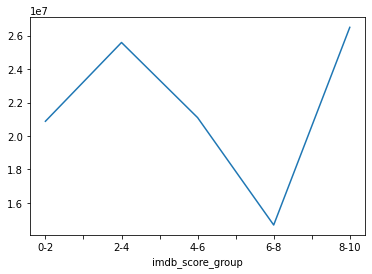

In [888]:
movies.groupby('imdb_score_group')['boxoffice'].median().plot()